<a href="https://colab.research.google.com/github/djakesa/AE-VAE-GAN-CelebA/blob/main/VAE_learnable_prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#On connecte mon drive au google collab

In [1]:
from google.colab import drive
import os
import shutil

# Démontage s'il est déjà monté
try:
    !fusermount -u /content/drive
except:
    pass

# Suppression du dossier de montage s'il reste
if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive', ignore_errors=True)

# Montage propre
drive.mount('/content/drive', force_remount=True)

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


#Importer la BDD via google drive

- J'ai déjà importé des photos de la BDD CelebA pour la suite lorsque j'ai construit mon AE à : /content/drive/MyDrive/img_align_celeba/img_align_celeba

- On va quand même tester si c'est ok avec ce path

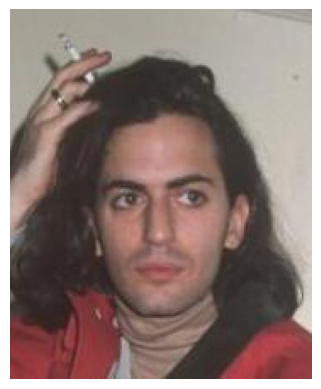

In [2]:
import cv2
import matplotlib.pyplot as plt

img= cv2.imread('/content/drive/MyDrive/img_align_celeba/img_align_celeba/002001.jpg')
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

#On va maintenant construire le VAE

In [11]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import Callback


# Learning rate scheduler
def step_decay_schedule(initial_lr=0.001, decay_factor=0.5, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** (epoch // step_size))
    return LearningRateScheduler(schedule, verbose=1)

# Callback avec affichage de mu et sigma
class LossHistoryPlotter(Callback):
    def __init__(self, sampling_layer):
        super().__init__()
        self.r_losses = []
        self.kl_losses = []
        self.sampling_layer = sampling_layer

    def on_train_begin(self, logs=None):
        print(f"{'Époque':>5} | {'r_loss':>10} | {'kl_loss':>10}")

    def on_epoch_end(self, epoch, logs=None):
        r_loss = logs.get('vae_r_loss')
        kl_loss = logs.get('loss') - r_loss

        self.r_losses.append(r_loss)
        self.kl_losses.append(kl_loss)

        print(f"{epoch+1:>5} | {r_loss:10.4f} | {kl_loss:10.4f}")

    def on_train_end(self, logs=None):
        mu_prior = np.mean(self.sampling_layer.mu_prior.numpy())
        sigma = np.mean(np.exp(0.5 * self.sampling_layer.log_var_prior.numpy()))

        print("\nDernière valeur du prior appris :")
        print(f"  μ (prior) moyen : {mu_prior:.4f}")
        print(f"  σ (prior) moyen : {sigma:.4f}")

        plt.figure(figsize=(10, 5))
        plt.plot(self.r_losses, label='Reconstruction Loss (r_loss)')
        plt.plot(self.kl_losses, label='KL Divergence')
        plt.title('Évolution des pertes')
        plt.xlabel('Époques')
        plt.ylabel('Valeur de la perte')
        plt.legend()
        plt.grid(True)
        plt.show()


# Couche de sampling avec prior apprenable
class Sampling(Layer):
    # **kwargs passe tout les arguments standards d'un layer
    def __init__(self, z_dim, **kwargs):
        # appelle le constructeur de la classe Layer de Keras
        super(Sampling, self).__init__(**kwargs)
        # initialise mu et log_var = 0 et comme des param trainable
        self.z_dim = z_dim
        self.mu_prior = self.add_weight(name='mu_prior', shape=(self.z_dim,), initializer='zeros', trainable=True)
        self.log_var_prior = self.add_weight(name='log_var_prior', shape=(self.z_dim,), initializer='zeros', trainable=True)

    def call(self, inputs):
        # inputs liste de deux tenseurs de l'encodeur
        mu, log_var = inputs
        # bruit aléatoire normal
        epsilon = tf.random.normal(shape=tf.shape(mu), mean=0.0, stddev=1.0)
        # trick de reparamétrisation rend z différentiable z environ N (mu, sigma^2)
        z = mu + tf.exp(0.5 * log_var) * epsilon

        # KL divergence entre sortie de l'encoder et prior appris

        kl_loss = -0.5 * tf.reduce_sum(
            1 + log_var - self.log_var_prior
            - tf.exp(log_var) / tf.exp(self.log_var_prior)
            - tf.square(mu - self.mu_prior) / tf.exp(self.log_var_prior),
            axis=1
        )
        # enregistre la perte dans model.losses puis l'ajoute lors de model.compile puis model.fit
        self.add_loss(tf.reduce_mean(kl_loss))
        return z

# Classe VAE
class VAE():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size,
                 decoder_conv_t_strides, z_dim, use_batch_norm=False, use_dropout=False):

        self.name = 'variational_autoencoder'
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
      encoder_input_layer = Input(shape=self.input_dim, name="encoder_input_layer")
      x = encoder_input_layer

      for i in range(self.n_layers_encoder):
          x = Conv2D(filters=self.encoder_conv_filters[i],
                    kernel_size=self.encoder_conv_kernel_size[i],
                    strides=self.encoder_conv_strides[i],
                    padding='same',
                    name=f'encoder_conv_{i}')(x)
          if self.use_batch_norm:
              x = BatchNormalization()(x)
          x = LeakyReLU()(x)
          if self.use_dropout:
              x = Dropout(0.25)(x)

      self.shape_before_flattening = K.int_shape(x)[1:]
      x = Flatten()(x)

      self.mu = Dense(self.z_dim, name='mu')(x)
      self.log_var = Dense(self.z_dim, name='log_var')(x)

      # Sampling + KL divergence
      self.sampling_layer = Sampling(z_dim=self.z_dim,name='encoder_output')
      # On appelle la couche sampling qu'on a créé ( class sampling )
      z = self.sampling_layer([self.mu, self.log_var])

      # ENCODER (pour sauvegarde/usage ultérieur)
      self.encoder = Model(encoder_input_layer, z)

      # DECODER
      decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
      x = Dense(np.prod(self.shape_before_flattening))(decoder_input)
      x = Reshape(self.shape_before_flattening)(x)

      for i in range(self.n_layers_decoder):
          x = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],
                              kernel_size=self.decoder_conv_t_kernel_size[i],
                              strides=self.decoder_conv_t_strides[i],
                              padding='same',
                              name=f'decoder_conv_t_{i}')(x)
          if i < self.n_layers_decoder - 1:
              if self.use_batch_norm:
                  x = BatchNormalization()(x)
              x = LeakyReLU()(x)
              if self.use_dropout:
                  x = Dropout(0.25)(x)
          else:
              x = Activation('sigmoid')(x)

      self.decoder = Model(decoder_input, x)

      # Important : on passe `z`, pas self.encoder(encoder_input_layer)
      model_output = self.decoder(z)
      self.model = Model(encoder_input_layer, model_output)

      # Ajout de la KL loss comme métrique visible
      if self.model.losses:
        self.model.add_metric(tf.reduce_mean(self.model.losses[0]), name="kl_loss", aggregation="mean")


    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate
        def vae_r_loss(y_true, y_pred):
            return r_loss_factor * K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss=vae_r_loss, metrics=[vae_r_loss])

    def train(self, x_train, batch_size, epochs, initial_epoch=0, callbacks=None, lr_decay=0.8):
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=10)
        if callbacks is None: callbacks = []
        callbacks.append(lr_sched)
        self.model.fit(x_train, x_train, batch_size=batch_size,
                       shuffle=True, epochs=epochs,
                       initial_epoch=initial_epoch,
                       callbacks=callbacks)

    def save(self, path):
        self.model.save(os.path.join(path, "vae_model.keras"), include_optimizer=False)
        self.encoder.save(os.path.join(path, "encoder_model.keras"), include_optimizer=False)
        self.decoder.save(os.path.join(path, "decoder_model.keras"), include_optimizer=False)

    def load(self, path):
        self.model = load_model(os.path.join(path, "vae_model.keras"), custom_objects={"Sampling": Sampling}, compile=False)
        self.encoder = load_model(os.path.join(path, "encoder_model.keras"), custom_objects={"Sampling": Sampling}, compile=False)
        self.decoder = load_model(os.path.join(path, "decoder_model.keras"), compile=False)


In [4]:
# Chargement de 1000 images CelebA depuis le dossier extrait
import cv2
import numpy as np
import os

image_dir = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'
image_paths = sorted([
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.endswith('.jpg')
])[:1000]  # pour un entraînement rapide

def load_images(paths):
    images = []
    for path in paths:
        img = cv2.imread(path)
        # Check if image was loaded correctly
        if img is None:
            print(f"Error loading image: {path}")
            continue  # Skip this image and proceed with the next
        img = cv2.resize(img, (128, 128))  # <<< réduction de taille ici
        img = img.astype('float32') / 255.0
        images.append(img)
    # Check if any images were loaded
    if not images:  # If images list is empty
        raise ValueError("No images were loaded. Check image paths and formats.")
    return np.array(images)

x_train = load_images(image_paths)

Error loading image: /content/drive/MyDrive/img_align_celeba/img_align_celeba/000165.jpg


In [12]:
vae = VAE(
    input_dim = (128,128,3)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,3]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 200
)

In [13]:
vae.encoder.summary()
vae.decoder.summary()
vae.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_layer │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_0      │ (None, 128, 128,  │        896 │ encoder_input_la… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 128, 128,  │          0 │ encoder_conv_0[0… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_1      │ (None, 64, 64,    │     18,496 │ leaky_re_lu_12[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 64, 64,    │          0 │ encoder_conv_1[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_2      │ (None, 32, 32,    │     36,928 │ leaky_re_lu_13[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 32, 32,    │          0 │ encoder_conv_2[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_3      │ (None, 32, 32,    │     36,928 │ leaky_re_lu_14[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 32, 32,    │          0 │ encoder_conv_3[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 65536)     │          0 │ leaky_re_lu_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 200)       │ 13,107,400 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 200)       │ 13,107,400 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_output      │ (None, 200)       │        400 │ mu[0][0],         │
│ (Sampling)          │                   │            │ log_var[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,308,448 (100.36 MB)

 Trainable params: 26,308,448 (100.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 65536)          │    13,172,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_0                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_1                │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_2                │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_3                │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,265,923 (50.61 MB)

 Trainable params: 13,265,923 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_layer │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_0      │ (None, 128, 128,  │        896 │ encoder_input_la… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 128, 128,  │          0 │ encoder_conv_0[0… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_1      │ (None, 64, 64,    │     18,496 │ leaky_re_lu_12[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 64, 64,    │          0 │ encoder_conv_1[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_2      │ (None, 32, 32,    │     36,928 │ leaky_re_lu_13[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 32, 32,    │          0 │ encoder_conv_2[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_3      │ (None, 32, 32,    │     36,928 │ leaky_re_lu_14[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 32, 32,    │          0 │ encoder_conv_3[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 65536)     │          0 │ leaky_re_lu_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 200)       │ 13,107,400 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 200)       │ 13,107,400 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_output      │ (None, 200)       │        400 │ mu[0][0],         │
│ (Sampling)          │                   │            │ log_var[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128, 128,  │ 13,265,923 │ encoder_output[0… │
│ (Functional)        │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,574,371 (150.96 MB)

 Trainable params: 39,574,371 (150.96 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
print("Perte(s) additionnelle(s) du modèle :", vae.model.losses)

Perte(s) additionnelle(s) du modèle : []


In [15]:
vae.compile(learning_rate=0.001, r_loss_factor=1000)

Époque |     r_loss |    kl_loss

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 124.7055 - vae_r_loss: 92.2205    1 |    88.8249 |    14.7752
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - loss: 124.0659 - vae_r_loss: 92.1176 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/200
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 73.5868 - vae_r_loss: 68.8623    2 |    60.7700 |     6.2670
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 73.1898 - vae_r_loss: 68.3719 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/200
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 56.2621 - vae_r_loss: 48.1851    3 |    47.4208 |     8.5261
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 56.2430 - vae_r_loss: 48.1388 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/200
31/32 ━━━━━━━━━━━━━━━━━━

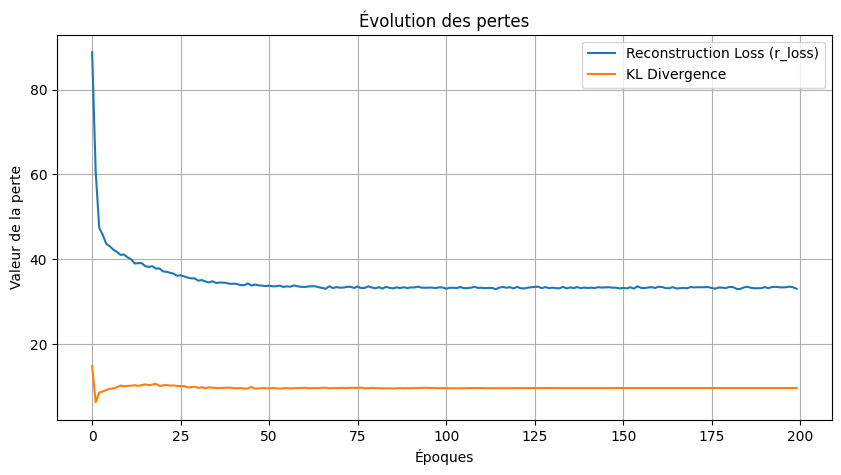

In [16]:
MODE = "build"  # "build" ou "load"
MODEL_DIR = "/content/vae_saved"

if MODE == "build":
    vae.train(
    x_train=x_train,
    batch_size=32,
    epochs=200,
    initial_epoch=0,
    lr_decay=0.5,
    callbacks=[
        LossHistoryPlotter(vae.sampling_layer)
    ]
)
    os.makedirs(MODEL_DIR, exist_ok=True)
    vae.save(MODEL_DIR)

elif MODE == "load":
    vae.load(MODEL_DIR)



# Test pour vérifier le surentrainement




In [20]:
image_dir_test = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'

image_paths_test = sorted([
    os.path.join(image_dir_test, fname)
    for fname in os.listdir(image_dir_test)
    if fname.endswith('.jpg')
])[1001:2000]  # on garde une portion pour un test rapide

def load_images_test(paths_test):
    images = []
    for path_test in paths_test:
        img = cv2.imread(path_test)
        if img is None:
            print(f"Error loading image: {path_test}")
            continue
        img = cv2.resize(img, (128, 128))
        img = img.astype('float32') / 255.0
        images.append(img)
    if not images:
        raise ValueError("No images were loaded.")
    return np.array(images)

x_test = load_images_test(image_paths_test)


In [22]:
vae.model.evaluate(x_test, x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 44.8695 - vae_r_loss: 35.5902


[44.385589599609375, 35.24654006958008]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


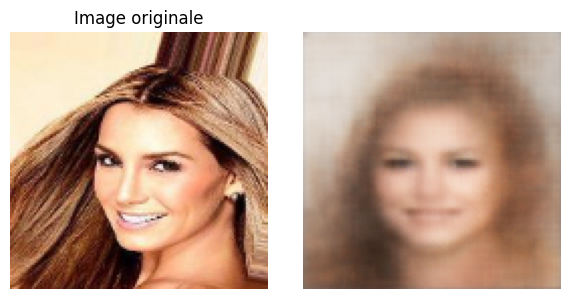

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


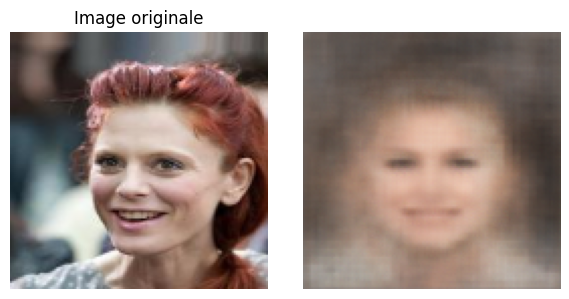

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


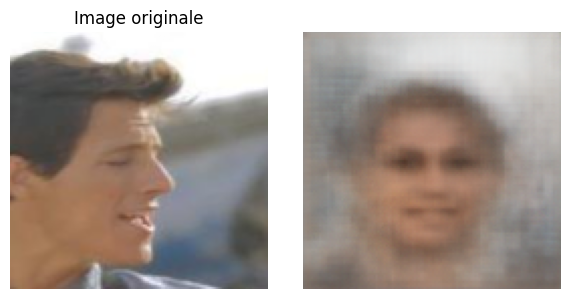

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


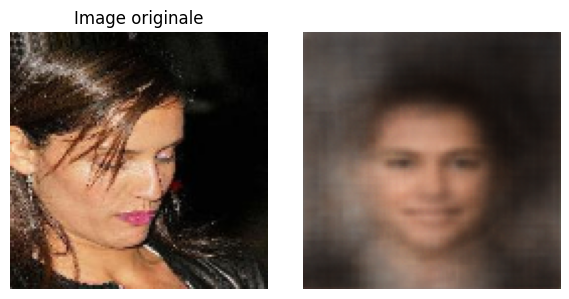

In [17]:
import matplotlib.pyplot as plt

for i in range(4):
    test_img = x_train[i]
    test_img_input = np.expand_dims(test_img, axis=0)

    reconstructed_img = vae.model.predict(test_img_input)[0]  # ou autoencodeur.model si renommé

    plt.figure(figsize=(6, 3))

    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(test_img[..., ::-1])  # BGR → RGB
    plt.title('Image originale')
    plt.axis('off')

    # Image reconstruite
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img)
    plt.imshow(reconstructed_img[..., ::-1])  # BGR → RGB
    plt.axis('off')

    plt.tight_layout()
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


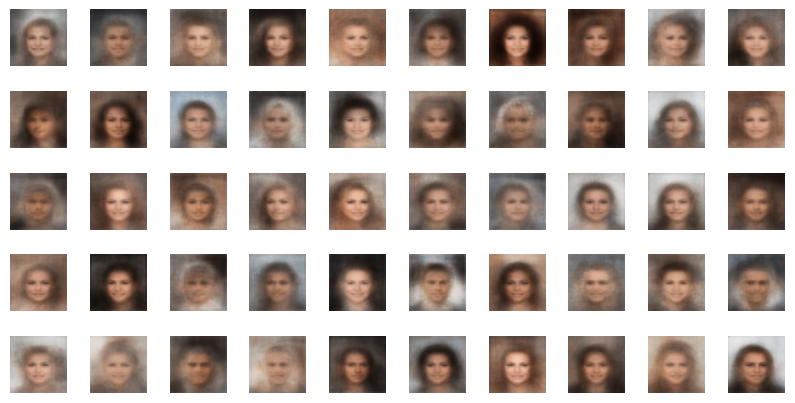

In [18]:
grid_size = 10
grid_depth = 5
z_random = np.random.normal(0, 1, size=(grid_size * grid_depth, vae.z_dim))

reconstructed_images = vae.decoder.predict(z_random)

fig = plt.figure(figsize=(grid_size, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconstructed_images[i, ..., ::-1])  # pas de cmap ici : c’est du RGB
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


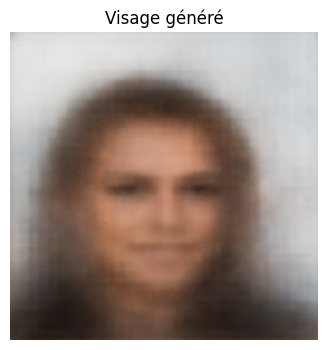

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Générer un seul point aléatoire dans l'espace latent
z_sample = np.random.normal(0, 1, size=(1, vae.z_dim))

# 2. Décoder en image RGB
generated_image = vae.decoder.predict(z_sample)[0]

# 3. Afficher
plt.figure(figsize=(4, 4))
plt.imshow(reconstructed_images[i, ..., ::-1])  # pas de cmap ici : c’est du RGB
plt.axis('off')
plt.title("Visage généré")
plt.show()
